<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/Network%20Architectures%20And%20Receptive%20Fields/ENAS-SkipConnectionsOnCIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, ENAS discovered network for Image classification on CIFAR10 is designed 

## ENAS - Efficient Neural Architecture Search - a neural network building another neural network

[ENAS Explanation](https://towardsdatascience.com/illustrated-efficient-neural-architecture-search-5f7387f9fb6#6ae7)

 


![ENAS](https://github.com/gkdivya/EVA/blob/master/Network%20Architectures%20And%20Receptive%20Fields/assets/ENAS.gif?raw=true)

### Importing libraries 

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.merge import concatenate
from keras.layers import MaxPooling2D, Input, SeparableConv2D, DepthwiseConv2D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, AveragePooling2D
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.utils import np_utils

import tensorflow as tf

Using TensorFlow backend.


### Loading CIFAR10 dataset 

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


**Visualiaze some sample Images from the dataset**

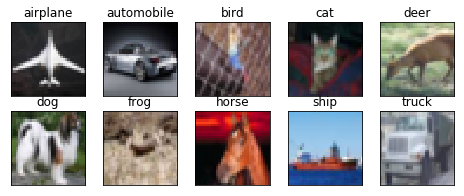

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Dividing pixel values by 255, standardize the inputs, also performed one hot encoding**

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

**Defining functions to plot model history, find accuracy**

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def accuracy_iterator(test_iterator, model):
  _, accuracy = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
  return (accuracy * 100)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)

### Define Model using Skip connections
A "skip connection" allows the gradient to be directly backpropagated to earlier layers:

![Skip Connection](https://github.com/gkdivya/EVA/blob/master/Network%20Architectures%20And%20Receptive%20Fields/assets/skipConnectionBasic.png?raw=true)


The image on the left shows the "main path" through the network without any skip connection. The image on the right adds a shortcut to the main path. 

ResNet blocks - Blocks with skip connections stacked on top of each other forms a deep network which performs better.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different.

ENAS discovered network uses skip connections where both input and output dimensions are same.

In [9]:
inputs = Input(shape=(32,32,3), name='ImageInput')
x1 = SeparableConv2D(16, (5,5), activation='relu', padding='same', name='x1')(inputs)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.1)(x1)

x2 = Conv2D(32, (5,5), activation='relu', padding='same', name='x2')(x1) 
x2 = BatchNormalization()(x2)
x2 = Dropout(0.1)(x2)

x3 = Conv2D(32, (5,5), activation='relu', padding='same', name='x3')(x2) 
x3 = BatchNormalization()(x3)
x3 = Dropout(0.1)(x3)

s1 = concatenate ([x1,x3]) 
x4 = SeparableConv2D(32, (5,5), activation='relu', padding='same', name='x4')(s1)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.1)(x4)

s2 = concatenate ([x1,x4]) 
pool1 = MaxPooling2D((2,2), name='pool1')(s2) #10
x5 = SeparableConv2D(16, (3,3), activation='relu', padding='same', name='x5')(pool1)
x5 = Conv2D(32, (1, 1), activation='relu')(x5)
x5 = BatchNormalization()(x5)
x5 = Dropout(0.1)(x5)

s3 = concatenate ([Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x4), x5], axis = -1) 
x6 = Conv2D(32, (5,5), activation='relu', padding='same', name='x6')(s3) 
x6 = BatchNormalization()(x6)
x6 = Dropout(0.1)(x6)

#print((Lambda(space_to_depth_x2)(x3)).shape, (Lambda(space_to_depth_x2)(x4)).shape, x5.shape, (x6).shape)
s4 = concatenate ([Lambda(space_to_depth_x2)(x3), Lambda(space_to_depth_x2)(x4), x5, x6]) 
x7 = SeparableConv2D(16, (3,3), activation='relu', padding='same', name='x7')(s4)
x7 = BatchNormalization()(x7)
x7 = Dropout(0.1)(x7)

s5 = concatenate ([Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x3), Lambda(space_to_depth_x2)(x4), x5, x6]) 
x8 = SeparableConv2D(32, (5,5), activation='relu', padding='same', name='x8')(s5)
x8 = BatchNormalization()(x8)
x8 = Dropout(0.1)(x8)

s6 = concatenate ([Lambda(space_to_depth_x2)(x1), Lambda(space_to_depth_x2)(x4), x5, x7, x8]) 
pool2 = MaxPooling2D((2,2), name='pool2')(s6) #10
#pool2 = Conv2D(32, (1, 1), activation='relu')(pool2)

s7 = concatenate ([Lambda(space_to_depth_x2)(x6), pool2]) 
x9 = Conv2D(16, (5,5), activation='relu', padding='same', name='x9')(s7) 
x9 = BatchNormalization()(x9)
x9 = Dropout(0.1)(x9)

s8 = concatenate ([Lambda(space_to_depth_x4)(x1), Lambda(space_to_depth_x4)(x2), Lambda(space_to_depth_x4)(x4), Lambda(space_to_depth_x2)(x7), x9]) 
x10 = SeparableConv2D(32, (3,3), activation='relu', padding='same', name='x10')(s8)
x10 = BatchNormalization()(x10)
x10 = Dropout(0.1)(x10)

s9 = concatenate ([Lambda(space_to_depth_x4)(x2), Lambda(space_to_depth_x4)(x3), Lambda(space_to_depth_x2)(x5), x9, x10]) 
x11 = Conv2D(32, (5,5), activation='relu', padding='same', name='x11')(s9) 
x11 = BatchNormalization()(x11)
x11 = Dropout(0.1)(x11)

s10 = concatenate ([Lambda(space_to_depth_x4)(x1), Lambda(space_to_depth_x4)(x3), Lambda(space_to_depth_x4)(x4), Lambda(space_to_depth_x2)(x5), Lambda(space_to_depth_x2)(x7), x10, x11]) 
x12 = SeparableConv2D(32, (5,5), activation='relu', padding='same', name='x12')(s10)
x12 = BatchNormalization()(x12)
x12 = Dropout(0.1)(x12)

s11 = concatenate ([Lambda(space_to_depth_x4)(x4), Lambda(space_to_depth_x2)(x7), x10, x12]) 

x13 = Conv2D(10, (1, 1))(s11)
x13 = AveragePooling2D(8,8)(x13)

flat = Flatten()(x13)
predictions = Activation('softmax')(flat)
model = Model(inputs=inputs, outputs=predictions)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
x1 (SeparableConv2D)            (None, 32, 32, 16)   139         ImageInput[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          x1[0][0]                         
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
# checkpoint
filepath="/content/drive/My Drive/NetworkArchitectures/ENAS-CIFAR10/Models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')

In [0]:
callbacks_list = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
98/98 [==============================] - 87s 885ms/step - loss: 1.4725 - acc: 0.4682 - val_loss: 1.9582 - val_acc: 0.3985

Epoch 00001: val_acc improved from -inf to 0.39850, saving model to /content/drive/My Drive/NetworkArchitectures/ENAS-CIFAR10/Models/weights-01-0.40.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
98/98 [==============================] - 75s 765ms/step - loss: 1.0671 - acc: 0.6202 - val_loss: 1.0770 - val_acc: 0.6254

Epoch 00002: val_acc improved from 0.39850 to 0.62540, saving model to /content/drive/My Drive/NetworkArchitectures/ENAS-CIFAR10/Models/weights-02-0.63.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
98/98 [==============================] - 75s 763ms/step - loss: 0.8635 - acc: 0.6945 - val_loss

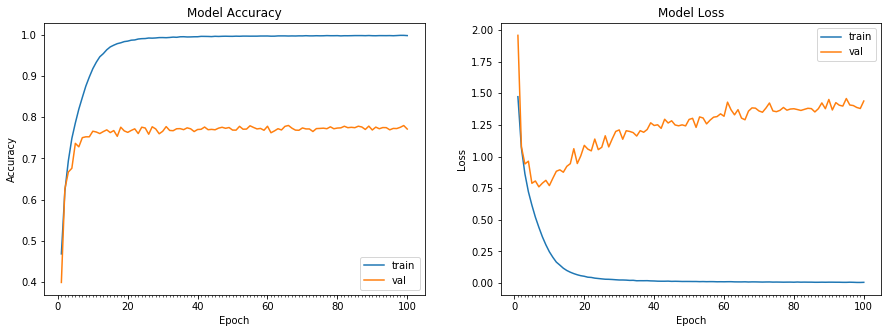

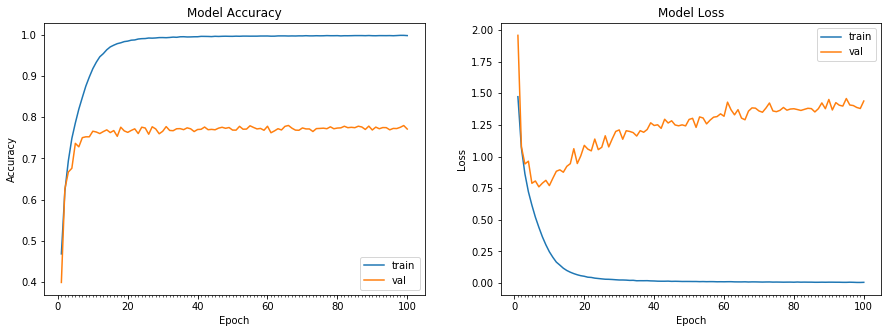

Accuracy on test data is: 77.14
Accuracy on test data is: 77.14


In [16]:
from keras.preprocessing.image import ImageDataGenerator

# applying transformation to image
train_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit the data augmentation
train_gen.fit(train_features)
test_gen.fit(test_features)

training_generator= train_gen.flow(train_features, train_labels, batch_size=512)
testing_generator= test_gen.flow(test_features, test_labels, batch_size=512, shuffle=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(training_generator, 
                    steps_per_epoch = len(training_generator),
                    epochs=100,
                    validation_data = testing_generator,
                    validation_steps = len(testing_generator),
                    callbacks = callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy_iterator(testing_generator, model))